Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']


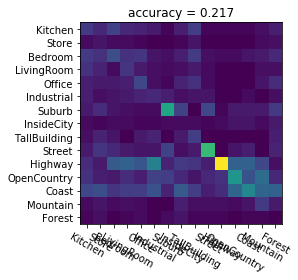

KeyboardInterrupt: 

In [126]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from scipy import stats
from pathlib import Path, PureWindowsPath


def extract_dataset_info(data_path):
    # extract information from train.txt
    f = open(os.path.join(data_path, "train.txt"), "r")
    contents_train = f.readlines()
    label_classes, label_train_list, img_train_list = [], [], []
    for sample in contents_train:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        if label not in label_classes:
            label_classes.append(label)
        label_train_list.append(sample[0])
        img_train_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))
    print('Classes: {}'.format(label_classes))

    # extract information from test.txt
    f = open(os.path.join(data_path, "test.txt"), "r")
    contents_test = f.readlines()
    label_test_list, img_test_list = [], []
    for sample in contents_test:
        sample = sample.split()
        label, img_path = sample[0], sample[1]
        label_test_list.append(label)
        img_test_list.append(os.path.join(data_path, Path(PureWindowsPath(img_path))))  # you can directly use img_path if you run in Windows

    return label_classes, label_train_list, img_train_list, label_test_list, img_test_list


def compute_dsift(img, stride, size):

    # print(img.shape)

    sift = cv2.xfeatures2d.SIFT_create()
    dense_feature = np.empty((0,128))
    x1=0

    while(x1+size < img.shape[0]):
        x2=0
        while(x2+size < img.shape[1]):

            keypoints= [cv2.KeyPoint(x1+size/4,x2+size/4,size/2),
                        cv2.KeyPoint(x1+3*size/4,x2+3*size/4,size/2),
                        cv2.KeyPoint(x1+size/4,x2+3*size/4,size/2),
                        cv2.KeyPoint(x1+3*size/4,x2+size/4,size/2)]

            _,des1 = sift.compute(img[x1:x1+size,x2:x2+size],keypoints)
            # print(dense_feature.shape)
            # print(des1.shape)
            if(len(des1)>=1):
                dense_feature = np.append(dense_feature,des1,axis=0)

            x2 += stride
        x1 += stride

    return dense_feature


def get_tiny_image(img, output_size):

    img = img.astype('float')/255.0

    feature = cv2.resize(img,output_size)
    feature = np.subtract(feature, np.average(feature))
    feature = np.divide(feature, np.std(feature))

    return feature


def predict_knn(feature_train, label_train, feature_test, k):
    

    nbrs = NearestNeighbors(n_neighbors=k).fit(feature_train)
    dist,indices = nbrs.kneighbors(feature_test)

    label_test_count = np.zeros((feature_test.shape[0],15))
    label_test_pred = np.zeros(feature_test.shape[0], dtype=int)

    for x1 in range(feature_test.shape[0]):
        for x2 in range(dist.shape[1]):
            label_test_count[x1] = np.add(label_test_count[x1],label_train[indices[x1,x2]])
        label_test_pred[x1] = np.argmax(label_test_count[x1])

    return label_test_pred


def classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    
    feature_train = np.zeros((len(label_train_list),256))
    label_train = np.zeros((len(label_train_list),15))
    feature_test = np.zeros((len(label_test_list),256))

    for x1 in range(len(label_train_list)):
        img = cv2.imread(img_train_list[x1], 0)
        feature = get_tiny_image(img, (16,16))
        feature_train[x1] = feature.flatten()
        label = np.zeros(15)
        label[label_classes.index(label_train_list[x1])] = 1
        label_train[x1] = label

    for x1 in range(len(label_test_list)):
        img = cv2.imread(img_test_list[x1], 0)
        feature = get_tiny_image(img, (16,16))
        feature_test[x1] = feature.flatten()

    label_test_pred = predict_knn(feature_train, label_train, feature_test, 5)

    confusion = np.zeros((15,15))

    for x1 in range(label_test_pred.shape[0]):

        confusion[label_test_pred[x1], label_classes.index(label_test_list[x1])] += 1

    accuracy =0

    for x1 in range(15):
        accuracy += confusion[x1,x1]

    accuracy = accuracy/label_test_pred.shape[0]

    visualize_confusion_matrix(confusion, accuracy, label_classes)

    return confusion, accuracy


def build_visual_dictionary(dense_feature_list, dic_size):
    

    km = KMeans(
    n_clusters=dic_size, init='random',
    n_init=1, max_iter=100, 
    tol=1e-04, random_state=0
    )

    y_km = km.fit(dense_feature_list)
    vocab = y_km.cluster_centers_

    print(vocab.shape)
    return vocab


def compute_bow(feature, vocab):

    bow_feature = np.zeros(vocab.shape[0])
    nbrs = NearestNeighbors(n_neighbors=1).fit(vocab)
    dist,indices = nbrs.kneighbors(feature)
    
    for x in range(dist.shape[0]):
        bow_feature[indices[x][0]] += 1

    bow_feature = np.divide(bow_feature, np.linalg.norm(bow_feature))

    return bow_feature


def classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    
    dense_feature_list = np.empty((0,128))
    for x1 in range(len(label_train_list)):
        img = cv2.imread(img_train_list[x1], 0)
        dense_feature = compute_dsift(img,30,100)
        dense_feature_list = np.append(dense_feature_list,dense_feature,axis=0)

    print(dense_feature_list.shape)
    dic_size = 100
    feature_train = np.zeros((len(label_train_list),dic_size))
    label_train = np.zeros((len(label_train_list),15))
    feature_test = np.zeros((len(label_test_list),dic_size))

    for x1 in range(len(label_train_list)):
        img = cv2.imread(img_train_list[x1], 0)
        dense_feature = compute_dsift(img,30,100)
        feature_train[x1] = compute_bow(dense_feature, vocab)
        label = np.zeros(15)
        label[label_classes.index(label_train_list[x1])] = 1
        label_train[x1] = label

    for x1 in range(len(label_test_list)):
        img = cv2.imread(img_test_list[x1], 0)
        dense_feature = compute_dsift(img,30,100)
        feature_test[x1] = compute_bow(dense_feature, vocab)

    label_test_pred = predict_knn(feature_train, label_train, feature_test, 5)

    confusion = np.zeros((15,15))

    for x1 in range(label_test_pred.shape[0]):

        confusion[label_test_pred[x1], label_classes.index(label_test_list[x1])] += 1

    accuracy =0

    for x1 in range(15):
        accuracy += confusion[x1,x1]

    accuracy = accuracy/label_test_pred.shape[0]

    visualize_confusion_matrix(confusion, accuracy, label_classes)


def predict_svm(feature_train, label_train, feature_test, n_classes):
    
    clf_list =[]
    label_test_pred = np.zeros(feature_test.shape[0], dtype=int)

    for x in range(n_classes):
        clf = LinearSVC(random_state=0, tol=1e-5, dual=False, C = 3.27)
        clf.fit(feature_train,label_train[:,x])
        clf_list.append(clf)
    

    for x1 in range(label_train.shape[0]):
        max = -100
        for x in range(n_classes):
            clf = clf_list[x]
            temp = clf.decision_function(np.reshape(feature_test[x1],(1,-1)))
            if(temp[0] >= max):
                max = temp[0]
                label_test_pred[x1] = x

    return label_test_pred


def classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list):
    
    dense_feature_list = np.empty((0,128))
    for x1 in range(len(label_train_list)):
        img = cv2.imread(img_train_list[x1], 0)
        dense_feature = compute_dsift(img,15,100)
        dense_feature_list = np.append(dense_feature_list,dense_feature,axis=0)

    print(dense_feature_list.shape)
    dic_size = 100
    feature_train = np.zeros((len(label_train_list),dic_size))
    label_train = np.zeros((len(label_train_list),15))
    feature_test = np.zeros((len(label_test_list),dic_size))

    for x1 in range(len(label_train_list)):
        img = cv2.imread(img_train_list[x1], 0)
        dense_feature = compute_dsift(img,15,100)
        feature_train[x1] = compute_bow(dense_feature, vocab)
        label = np.zeros(15)
        label[label_classes.index(label_train_list[x1])] = 1
        label_train[x1] = label

    for x1 in range(len(label_test_list)):
        img = cv2.imread(img_test_list[x1], 0)
        dense_feature = compute_dsift(img,15,100)
        feature_test[x1] = compute_bow(dense_feature, vocab)
        
    label_test_pred = predict_svm(feature_train, label_train, feature_test, 15)

    confusion = np.zeros((15,15))

    for x1 in range(label_test_pred.shape[0]):

        confusion[label_classes.index(label_test_list[x1]), label_test_pred[x1]] += 1

    accuracy =0

    for x1 in range(15):
        accuracy += confusion[x1,x1]

    accuracy = accuracy/label_test_pred.shape[0]

    visualize_confusion_matrix(confusion, accuracy, label_classes)
    

def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    # set horizontal alignment mode (left, right or center) and rotation mode(anchor or default)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="center", rotation_mode="default")
    # avoid top and bottom part of heatmap been cut
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    
    label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")

    classify_knn_tiny(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

    classify_knn_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

    classify_svm_bow(label_classes, label_train_list, img_train_list, label_test_list, img_test_list)

In [122]:
label_classes, label_train_list, img_train_list, label_test_list, img_test_list = extract_dataset_info("./scene_classification_data")

dense_feature_list = np.empty((0,128))
for x1 in range(len(label_train_list)):
    img = cv2.imread(img_train_list[x1], 0)
    dense_feature = compute_dsift(img,30,100)
    dense_feature_list = np.append(dense_feature_list,dense_feature,axis=0)

print(dense_feature_list.shape)

Classes: ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office', 'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street', 'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']
(197616, 128)


In [123]:
vocab = build_visual_dictionary(dense_feature_list,100)

(100, 128)


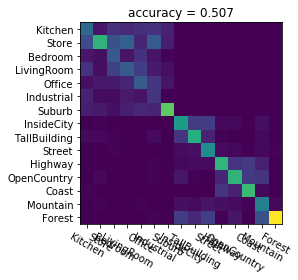

In [124]:
dic_size = 100
sift = cv2.xfeatures2d.SIFT_create()
feature_train = np.zeros((len(label_train_list),dic_size))
label_train = np.zeros((len(label_train_list),15))
feature_test = np.zeros((len(label_test_list),dic_size))

for x1 in range(len(label_train_list)):
    img = cv2.imread(img_train_list[x1], 0)
    dense_feature = compute_dsift(img,30,100)
    feature_train[x1] = compute_bow(dense_feature, vocab)
    label = np.zeros(15)
    label[label_classes.index(label_train_list[x1])] = 1
    label_train[x1] = label

for x1 in range(len(label_test_list)):
    img = cv2.imread(img_test_list[x1], 0)
    dense_feature = compute_dsift(img,30,100)
    feature_test[x1] = compute_bow(dense_feature, vocab)

label_test_pred = predict_knn(feature_train, label_train, feature_test, 5)

confusion = np.zeros((15,15))

for x1 in range(label_test_pred.shape[0]):

    confusion[label_test_pred[x1], label_classes.index(label_test_list[x1])] += 1

accuracy =0

for x1 in range(15):
    accuracy += confusion[x1,x1]

accuracy = accuracy/label_test_pred.shape[0]

visualize_confusion_matrix(confusion, accuracy, label_classes)

In [116]:
dic_size = 100
sift = cv2.xfeatures2d.SIFT_create()
feature_train = np.zeros((len(label_train_list),dic_size))
label_train = np.zeros((len(label_train_list),15))
feature_test = np.zeros((len(label_test_list),dic_size))

for x1 in range(len(label_train_list)):
    img = cv2.imread(img_train_list[x1], 0)
    dense_feature = compute_dsift(img,15,100)
    feature_train[x1] = compute_bow(dense_feature, vocab)
    label = np.zeros(15)
    label[label_classes.index(label_train_list[x1])] = 1
    label_train[x1] = label

for x1 in range(len(label_test_list)):
    img = cv2.imread(img_test_list[x1], 0)
    dense_feature = compute_dsift(img,15,100)
    feature_test[x1] = compute_bow(dense_feature, vocab)

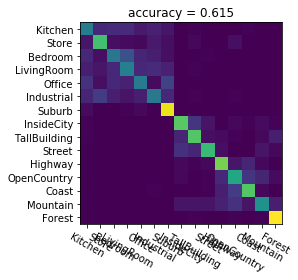

In [119]:
# max =0
# max_x = 0
# for x in range(300,400):
label_test_pred = predict_svm(feature_train, label_train, feature_test, 3.27)

confusion = np.zeros((15,15))

for x1 in range(label_test_pred.shape[0]):

    confusion[label_classes.index(label_test_list[x1]), label_test_pred[x1]] += 1

accuracy =0

for x1 in range(15):
    accuracy += confusion[x1,x1]

accuracy = accuracy/label_test_pred.shape[0]

# print(accuracy)

#     if(accuracy >= max):
#         max = accuracy
#         max_x = x

# print(max_x,max)

visualize_confusion_matrix(confusion, accuracy, label_classes)